# Bias in word embeddings

These materials are a partial replication of [Bolukbasi et al. 2016](https://arxiv.org/pdf/1607.06520.pdf) "Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings", and their assessment by [Gonen and Goldberg 2019](https://arxiv.org/pdf/1903.03862.pdf) "Lipstick on a Pig: Debiasing Methods Cover up Systematic Gender Biases in Word Embeddings But do not Remove Them".

For a detailed explanation of the experiments, see the original papers. 

*This notebook is largely based on Gonen and Goldberg's code, which can be found here: https://github.com/gonenhila/gender_bias_lipstick (a link to the embeddings is given there).*

We use the Word2Vec model from https://code.google.com/archive/p/word2vec, and its debiased version from [Bolukbasi et al. 2016](https://arxiv.org/pdf/1607.06520.pdf)).

### Load embeddings

In [1]:
import codecs
import numpy as np
from numpy import linalg as LA

def load_embeddings_from_np(filename):
    print('loading ...')
    with codecs.open(filename + '.vocab', 'r', 'utf-8') as f_embed:
        vocab = [line.strip() for line in f_embed]
        
    w2i = {w: i for i, w in enumerate(vocab)}
    wv = np.load(filename + '.wv.npy')

    return vocab, wv, w2i


def normalize(wv):
    
    # normalize vectors
    norms = np.apply_along_axis(LA.norm, 1, wv)
    wv = wv / norms[:, np.newaxis]
    return wv


def load_and_normalize(space, filename, vocab, wv, w2i):
    vocab_muse, wv_muse, w2i_muse = load_embeddings_from_np(filename)
    wv_muse = normalize(wv_muse)
    vocab[space] = vocab_muse 
    wv[space] = wv_muse
    w2i[space] = w2i_muse
    print('done')

In [2]:
vocab = {}
wv = {}
w2i = {}

load_and_normalize('bef', '../data/embeddings/orig_w2v', vocab, wv, w2i)
load_and_normalize('aft', '../data/embeddings/hard_debiased_w2v', vocab, wv, w2i)

loading ...
done
loading ...
done


In [3]:
from tqdm import tqdm

def topK(w, space, k=10):
    
    # extract the word vector for word w
    idx = w2i[space][w]
    vec = wv[space][idx, :]
    
    # compute similarity of w with all words in the vocabulary
    sim = wv[space].dot(vec)
    # sort similarities by descending order
    sort_sim = (sim.argsort())[::-1]

    # choose topK
    best = sort_sim[:(k+1)]

    return [vocab[space][i] for i in best if i!=idx]

def similarity(w1, w2, space):
    
    i1 = w2i[space][w1]
    i2 = w2i[space][w2]
    vec1 = wv[space][i1, :]
    vec2 = wv[space][i2, :]

    return np.inner(vec1,vec2)

### Restrict vocabulary

In [4]:
import string 


def has_punct(w):
    
    if any([c in string.punctuation for c in w]):
        return True
    return False

def has_digit(w):
    
    if any([c in '0123456789' for c in w]):
        return True
    return False

def limit_vocab(space, exclude = None):
    vocab_limited = []
    for w in tqdm(vocab[space][:50000]): 
        if w.lower() != w:
            continue
        if len(w) >= 20:
            continue
        if has_digit(w):
            continue
        if '_' in w:
            p = [has_punct(subw) for subw in w.split('_')]
            if not any(p):
                vocab_limited.append(w)
            continue
        if has_punct(w):
            continue
        vocab_limited.append(w)
    
    if exclude:
        vocab_limited = list(set(vocab_limited) - set(exclude))
    
    print("size of vocabulary:", len(vocab_limited))
    
    wv_limited = np.zeros((len(vocab_limited), 300))
    for i,w in enumerate(vocab_limited):
        wv_limited[i,:] = wv[space][w2i[space][w],:]
    
    w2i_limited = {w: i for i, w in enumerate(vocab_limited)}
    
    return vocab_limited, wv_limited, w2i_limited

In [5]:
# create the reduced vocabularies and embeddings before and after, without gendered specific words

import json
with codecs.open('../data/lists/gender_specific_full.json') as f:
    gender_specific = json.load(f)
with codecs.open('../data/lists/definitional_pairs.json') as f:
    definitional_pairs = json.load(f)
with codecs.open('../data/lists/equalize_pairs.json') as f:
    equalize_pairs = json.load(f)

exclude_words = []
for pair in definitional_pairs + equalize_pairs:
    exclude_words.append(pair[0])
    exclude_words.append(pair[1])

exclude_words = list(set(exclude_words).union(set(gender_specific)))

# create spaces of limited vocabulary
vocab['limit_bef'], wv['limit_bef'], w2i['limit_bef'] = limit_vocab('bef', exclude = exclude_words)
vocab['limit_aft'], wv['limit_aft'], w2i['limit_aft'] = limit_vocab('aft', exclude = exclude_words)

assert(vocab['limit_aft'] == vocab['limit_bef'])

100%|██████████| 50000/50000 [00:00<00:00, 528301.77it/s]


size of vocabulary: 26189


100%|██████████| 50000/50000 [00:00<00:00, 617848.85it/s]


size of vocabulary: 26189


### Compute bias-by-projection

In [6]:
# create a dictionary of the bias, before and after

def compute_bias_by_projection(space_to_tag, full_space):
    males = wv[space_to_tag].dot(wv[full_space][w2i[full_space]['he'],:])
    females = wv[space_to_tag].dot(wv[full_space][w2i[full_space]['she'],:])
    d = {}
    for w,m,f in zip(vocab[space_to_tag], males, females):
        d[w] = m-f
    return d

# compute bias-by-projection before and after debiasing
gender_bias_bef = compute_bias_by_projection('limit_bef', 'bef')
gender_bias_aft = compute_bias_by_projection('limit_aft', 'aft')

In [17]:
gender_bias_bef["plumber"]

0.0771652838544552

In [18]:
gender_bias_bef["manager"]

0.07281604195231672

In [13]:
gender_bias_bef["doctor"]

-0.00299872895471176

In [12]:
gender_bias_bef["professor"]

-0.021703316951948354

In [10]:
gender_bias_bef["nurse"]

-0.24709449195517097

In [21]:
gender_bias_aft["plumber"]

9.203681428093802e-10

In [20]:
gender_bias_aft["nurse"]

5.8358252119639076e-09

In [24]:
# calculate the avg bias of the vocabulary (in absolute terms) before and after debiasing

def report_bias(gender_bias):
    bias = 0.0
    for k in gender_bias:
        bias += np.abs(gender_bias[k])
    print(bias/len(gender_bias))
report_bias(gender_bias_bef)
report_bias(gender_bias_aft)

0.04607731006352767
2.627982224995115e-09


### Compute the gender subspace

In [129]:
gender_subspace = np.empty([0,len(wv['bef'][w2i['bef']['he'],:])])

In [130]:
for p in definitional_pairs:
    # remember to normalise to one again
    diff = wv['bef'][w2i['bef'][p[0]],:] - wv['bef'][w2i['bef'][p[1]],:] # note this time we do she - he
    dn = np.linalg.norm(diff)
    diff = diff/dn
    gender_subspace = np.vstack((gender_subspace, diff))

In [131]:
gender_subspace.shape

(10, 300)

In [132]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(gender_subspace)

PCA(n_components=10)

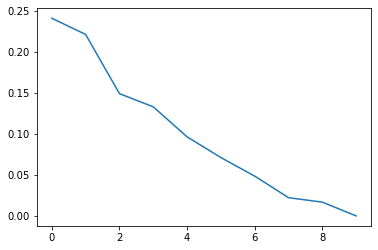

In [149]:
# Cf. Figure 6 in Bolukbasi: it seems 2-3 components would be relevant here 

plt.plot(pca.explained_variance_ratio_)

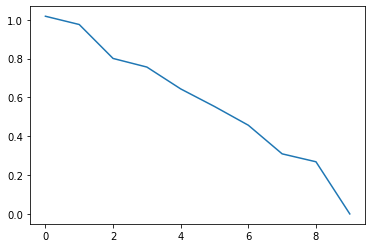

In [150]:
plt.plot(pca.singular_values_)

In [152]:
# create a dictionary of the bias, before and after, using the gender subspace

def compute_bias_by_projection_subspace(space_to_tag, subspace, c=1, wordlist=[]):
    d = 0
    n = 0
    if len(wordlist)==0:
        wordlist = vocab[space_to_tag]
    for w in wordlist:
        if w in w2i[space_to_tag]:
            d += np.abs((wv[space_to_tag][w2i[space_to_tag][w],:]@subspace))**c
            n += 1
    return d/n

# compute bias-by-projection before and after debiasing
gender_bias_sub = compute_bias_by_projection_subspace('limit_bef', pca.components_[0]) # we use the first component as in Bolukbasi

In [153]:
print(gender_bias_sub)

0.04943383608049832


In [154]:
def extract_professions():
    professions = []
    with codecs.open('../data/lists/professions.json', 'r', 'utf-8') as f:
        professions_data = json.load(f)
    for item in professions_data:
        professions.append(item[0].strip())
    return professions

professions = extract_professions()

In [155]:
professions[:10]

['accountant',
 'acquaintance',
 'actor',
 'actress',
 'adjunct_professor',
 'administrator',
 'adventurer',
 'advocate',
 'aide',
 'alderman']

In [156]:
gender_bias_sub_professions = compute_bias_by_projection_subspace('limit_bef', pca.components_[0], wordlist=professions) # we use the first component as in Bolukbasi

In [157]:
gender_bias_sub_professions

0.05285617336027109

In [ ]:
# Compare with Bolukbasi, Section 5.2